In [243]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
weekly_table = nfl.import_weekly_data([2023, 2022])
yearly_table = nfl.import_seasonal_data([2023, 2022])
weekly = pd.DataFrame(weekly_table)
yearly = pd.DataFrame(yearly_table)

weekly['half_ppr'] = (weekly['fantasy_points'] + weekly['fantasy_points_ppr']) / 2
yearly['half_ppr'] = (yearly['fantasy_points'] + yearly['fantasy_points_ppr']) / 2

qb_weekly = weekly[weekly['position_group'] == 'QB']
rb_weekly = weekly[weekly['position_group'] == 'RB']
wr_weekly = weekly[weekly['position_group'] == 'WR']
te_weekly = weekly[weekly['position_group'] == 'TE']
k_weekly = weekly[weekly['position'] == 'K']

qbs = qb_weekly[["player_id", "player_name", "season", "recent_team"]].drop_duplicates()
rbs = rb_weekly[["player_id", "player_name", "season", "recent_team"]].drop_duplicates()
wrs = wr_weekly[["player_id", "player_name", "season", "recent_team"]].drop_duplicates()
tes = te_weekly[["player_id", "player_name", "season", "recent_team"]].drop_duplicates()
ks = k_weekly[["player_id", "player_name", "season", "recent_team"]].drop_duplicates()

qb_yearly = pd.merge(yearly, qbs, how="inner", on=['player_id', 'season'])
rb_yearly = pd.merge(yearly, rbs, how="inner", on=['player_id', 'season'])
wr_yearly = pd.merge(yearly, wrs, how="inner", on=['player_id', 'season'])
te_yearly = pd.merge(yearly, tes, how="inner", on=['player_id', 'season'])
k_yearly = pd.merge(yearly, ks, how="inner", on=['player_id', 'season'])

# training_wrs = wr_yearly[wr_yearly['season'] == 2022].merge(wr_yearly[wr_yearly['season'] == 2023], qbs, how="inner", on=['player_id', 'season'])

wr_yearly = wr_yearly[(wr_yearly.groupby('player_id').transform('size') == 2) & (wr_yearly.groupby(['player_id','season']).transform('size') == 1)]
qb_yearly = qb_yearly[qb_yearly.groupby('player_id').transform('size') == 2]
rb_yearly = rb_yearly[rb_yearly.groupby('player_id').transform('size') == 2]
te_yearly = te_yearly[te_yearly.groupby('player_id').transform('size') == 2]
k_yearly = k_yearly[k_yearly.groupby('player_id').transform('size') == 2]

Downcasting floats.


C:\Users\twgeh\AppData\Local\Temp\ipykernel_12604\2342290292.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.16606127]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  wr_yearly.loc[(wr_yearly['player_id'] == player['player_id']) & (wr_yearly['season'] == player['season']), 'GehrScore'] += cor_values[x_lab] * (player[x_lab] / max_values[x_lab])


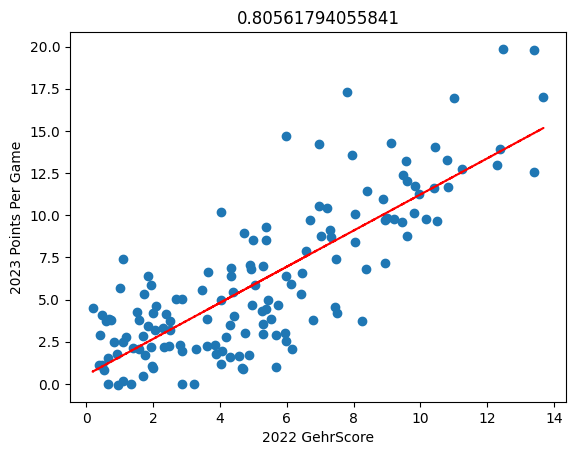

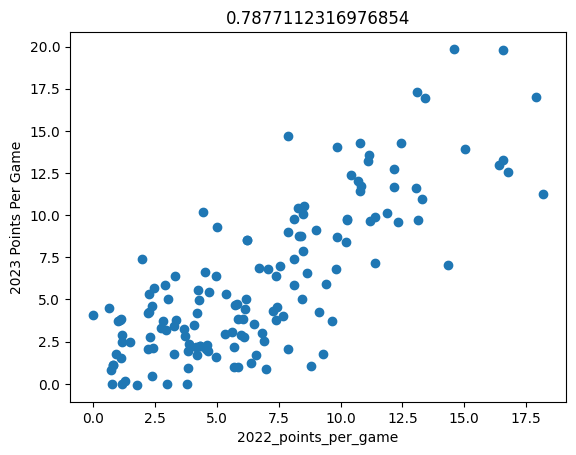

In [320]:
half_ppr = 'half_ppr'

rec_x_labs = ['receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_air_yards',
       'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
       'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share',
       'wopr_x','tgt_sh', 'ay_sh', 'yac_sh', 'wopr_y', 'ry_sh',
       'rfd_sh', 'rtdfd_sh','points_per_touchdown']

wr_yearly['points_per_game'] = wr_yearly[half_ppr] / wr_yearly['games']
wr_yearly['GehrScore'] = 0

wr_yearly['points_per_touchdown'] = (wr_yearly['half_ppr'] / (wr_yearly['receiving_tds'] + wr_yearly['games']))

cor_values = {}
max_values = {}
for x_labs in rec_x_labs:
    custom_weight = 1
    cor_values[x_labs] = (np.corrcoef(wr_yearly[x_labs], wr_yearly[half_ppr])[0][1]) ** 2
    max_values[x_labs] = wr_yearly[x_labs].max()

for x_lab in rec_x_labs:
    for i, player in wr_yearly.iterrows():
            wr_yearly.loc[(wr_yearly['player_id'] == player['player_id']) & (wr_yearly['season'] == player['season']), 'GehrScore'] += cor_values[x_lab] * (player[x_lab] / max_values[x_lab])
    

# wr_yearly[['player_name','target_share','half_ppr']].sort_values(by='', ascending=True)

wr_predictions = pd.DataFrame()
for player in wr_yearly['player_id'].unique():
    wr_prediction = pd.DataFrame()
    wr_prediction['player_name'] = wr_yearly[(wr_yearly['player_id'] == player) & (wr_yearly['season'] == 2022)]['player_name'].values
    same_team = (wr_yearly[(wr_yearly['player_id'] == player) & (wr_yearly['season'] == 2022)]['recent_team'].values == wr_yearly[(wr_yearly['player_id'] == player) & (wr_yearly['season'] == 2023)]['recent_team'].values)
    wr_prediction['same_team'] = 'yes' if same_team else 'no'
    wr_prediction['2022_half_ppr'] = wr_yearly[(wr_yearly['player_id'] == player) & (wr_yearly['season'] == 2022)]['half_ppr'].values
    wr_prediction['2023_half_ppr'] = wr_yearly[(wr_yearly['player_id'] == player) & (wr_yearly['season'] == 2023)]['half_ppr'].values
    wr_prediction['2022_points_per_game'] = wr_yearly[(wr_yearly['player_id'] == player) & (wr_yearly['season'] == 2022)]['points_per_game'].values
    wr_prediction['2023_points_per_game'] = wr_yearly[(wr_yearly['player_id'] == player) & (wr_yearly['season'] == 2023)]['points_per_game'].values
    wr_prediction['2022 GehrScore'] = wr_yearly[(wr_yearly['player_id'] == player) & (wr_yearly['season'] == 2022)]['GehrScore'].values
    wr_prediction['points_per_game_diff'] = wr_prediction['2023_points_per_game'] - wr_prediction['2022_points_per_game'].values
    wr_predictions = pd.concat([wr_predictions, wr_prediction], ignore_index=True)

# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):   
#     print(wr_predictions[wr_predictions['same_team'] == 'yes'])

wr_predictions_same_team = wr_predictions[(np.isinf(wr_predictions['2022 GehrScore'].values) == False)]

plt.figure(1)
plt.scatter(wr_predictions_same_team['2022 GehrScore'], wr_predictions_same_team['2023_points_per_game'])
z = np.polyfit(wr_predictions_same_team['2022 GehrScore'], wr_predictions_same_team['2023_points_per_game'], 1)
p = np.poly1d(z)
plt.xlabel('2022 GehrScore')
plt.ylabel('2023 Points Per Game')
plt.title(np.corrcoef(wr_predictions_same_team['2022 GehrScore'], wr_predictions_same_team['2023_points_per_game'])[0][1])
plt.plot(wr_predictions_same_team['2022 GehrScore'], p(wr_predictions_same_team['2022 GehrScore']), "r--")

plt.figure(2)
plt.scatter(wr_predictions_same_team['2022_points_per_game'], wr_predictions_same_team['2023_points_per_game'])
# z2 = np.polyfit(wr_predictions_same_team['2022_points_per_game'], wr_predictions_same_team['2023_points_per_game'], 1)
# p2 = np.poly1d(z2)
plt.xlabel('2022_points_per_game')
plt.ylabel('2023 Points Per Game')
plt.title(np.corrcoef(wr_predictions_same_team['2022_points_per_game'], wr_predictions_same_team['2023_points_per_game'])[0][1])
# plt.plot(wr_predictions_same_team['2022_points_per_game'], p2(wr_predictions_same_team['2022 GehrScore']), "r--")

plt.show()



In [321]:
wr_projections = pd.read_csv('FantasyPros_Fantasy_Football_Projections_WR.csv')
wr_projections = wr_projections.add_suffix('_2024')
wr_projections['player_name'] = wr_projections['Player_2024'].str.get(0) + '.' + wr_projections['Player_2024'].str.split(' ').str[1]

wr_stats_2024 = pd.merge(wr_projections, wr_yearly, how="inner", on=['player_name'])
wr_yearly['AppliedGehrScore'] = 0

In [339]:
for x_labs in wr_stats_2024.columns:
    if wr_stats_2024[x_labs].dtype == 'float64':
        cor_values[x_labs] = (np.corrcoef(wr_stats_2024[x_labs], wr_stats_2024[half_ppr])[0][1]) ** 2
        max_values[x_labs] = wr_stats_2024[x_labs].max()

c:\Users\twgeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\twgeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [354]:
wr_gehr_scores = wr_stats_2024[wr_stats_2024['season'] == 2023]

for x_lab in rec_x_labs:
    for i, player in wr_gehr_scores.iterrows():
            if x_lab == "receving_yards":
                wr_gehr_scores.loc[(wr_gehr_scores['player_id'] == player['player_id']), 'AppliedGehrScore'] += cor_values[x_lab] * (player['YDS_2024'] / max_values['YDS_2024'])
            elif x_lab == "receiving_tds":
                wr_gehr_scores.loc[(wr_gehr_scores['player_id'] == player['player_id']), 'AppliedGehrScore'] += cor_values[x_lab] * (player['TDS_2024'] / max_values['TDS_2024']) * 0.5
            elif x_lab == "receptions":
                wr_gehr_scores.loc[(wr_gehr_scores['player_id'] == player['player_id']), 'AppliedGehrScore'] += cor_values[x_lab] * (player['REC_2024'] / max_values['REC_2024'])
            elif x_lab == "half_ppr":
                wr_gehr_scores.loc[(wr_gehr_scores['player_id'] == player['player_id']), 'AppliedGehrScore'] += cor_values[x_lab] * (player['FPTS_2024'] / max_values['FPTS_2024'])

wr_gehr_scores['AGS Rank'] = wr_gehr_scores['AppliedGehrScore'].rank(ascending=False)
wr_gehr_scores['FPTS Rank'] = wr_gehr_scores['FPTS_2024'].rank(ascending=False)
wr_gehr_scores['Rank Diff'] = wr_gehr_scores['FPTS Rank'] - wr_gehr_scores['AGS Rank']

# print(wr_gehr_scores)
print(wr_gehr_scores[['player_name', 'AGS Rank', 'FPTS Rank', 'Rank Diff', 'AppliedGehrScore', 'FPTS_2024']].sort_values(by='AppliedGehrScore', ascending=False))

            player_name  AGS Rank  FPTS Rank  Rank Diff  AppliedGehrScore  \
1                C.Lamb       1.0        1.0        0.0         13.537893   
3                T.Hill       2.0        2.0        0.0         13.220668   
5               J.Chase       3.0        3.0        0.0         12.551264   
9               A.Brown       4.0        5.0        1.0         11.453377   
7           J.Jefferson       5.0        4.0       -1.0         11.372446   
11             G.Wilson       6.0        6.0        0.0         11.198670   
17              M.Evans       7.0        8.5        1.5         10.118264   
35              D.Moore       8.5       18.0        9.5         10.094347   
177             D.Moore       8.5       89.0       80.5         10.094347   
25               C.Kupp      10.0       13.0        3.0         10.086987   
19              D.Adams      11.0       10.0       -1.0         10.069505   
15             D.London      12.0        8.5       -3.5         10.047444   

C:\Users\twgeh\AppData\Local\Temp\ipykernel_12604\715886319.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wr_gehr_scores['AGS Rank'] = wr_gehr_scores['AppliedGehrScore'].rank(ascending=False)
C:\Users\twgeh\AppData\Local\Temp\ipykernel_12604\715886319.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wr_gehr_scores['FPTS Rank'] = wr_gehr_scores['FPTS_2024'].rank(ascending=False)
C:\Users\twgeh\AppData\Local\Temp\ipykernel_12604\715886319.py:16: SettingWithCopyWarning: 
A value is trying to be set 